# Power Predict 

The first step is to upload the data and pre-process it.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from google.cloud import bigquery
import pandas_gbq
## from colorama import Fore, Style
from pathlib import Path
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

## 1. We import the first file of the project 'Electricity_Data_Explorer.csv'

In [2]:
electricity_data_explorer = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/Electricity_Data_Explorer.csv')

In [3]:
electricity_data_explorer

,Country,Time,Balance,Product,Value,Unit
0,Australia,July 2023,Net Electricity Production,Electricity,22460.2248,GWh
1,Australia,July 2023,Net Electricity Production,Total Combustible Fuels,15153.4307,GWh
2,Australia,July 2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",10684.9635,GWh
3,Australia,July 2023,Net Electricity Production,Oil and Petroleum Products,360.4031,GWh
4,Australia,July 2023,Net Electricity Production,Natural Gas,3848.6375,GWh
...,...,...,...,...,...,...
134466,IEA Total,January 2010,Total Imports,Electricity,34846.5580,GWh
134467,IEA Total,January 2010,Total Exports,Electricity,32372.5830,GWh
134468,IEA Total,January 2010,Used for pumped storage,Electricity,6869.2530,GWh
134469,IEA Total,January 2010,Distribution Losses,Electricity,62000.7330,GWh


In [4]:
products = electricity_data_explorer['Product'].unique()
##products

### We create a list to be used as a filter on specific countries:

In [5]:
##filter_countries = ['Australia', 'Germany']

##['Germany', 'Argentina', 'Mexico', 'Canada', 'Spain', 'Norway', 'England', 'Tunisia', 'Morocco', 'Nigeria', 
            ## 'South Africa', 'Angola', 'Turkey', 'Iran', 'Australia', 'Thailand', 'Japan', 'South Korea', 'Liberia', 'France']

### We create a list to be used as a filter on the outputs:

In [6]:
filter_balance = ['Net Electricity Production']
                  ##, 'Final Consumption (Calculated)']

### We create a list to be used as a filter on the different sources of energy:

In [7]:
filter_products = ['Combustible Renewables', 'Hydro', 'Wind', 'Solar',
                   'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Other Renewables']

### We apply the filters to the initial dataframe:

In [8]:
electricity_data_explorer = electricity_data_explorer[electricity_data_explorer['Product'].isin(filter_products)]
## electricity_data_explorer

In [9]:
##electricity_data_explorer = electricity_data_explorer[electricity_data_explorer['Country'].isin(filter_countries)]

In [10]:
electricity_data_explorer = electricity_data_explorer[electricity_data_explorer['Balance'].isin(filter_balance)]
##electricity_data_explorer

### Reordering the columns

In [11]:
electricity_data_explorer = electricity_data_explorer[['Time', 'Country', 'Balance','Product','Value']]
#electricity_data_explorer

### Reindexing the dataframe

In [12]:
electricity_data_explorer.index = range(len(electricity_data_explorer.index))
#electricity_data_explorer

In [13]:
electricity_data_explorer = electricity_data_explorer.pivot_table('Value', ['Time','Country', 'Balance'], 'Product')

In [14]:
electricity_data_explorer = electricity_data_explorer.fillna(0)
#electricity_data_explorer

In [15]:
electricity_data_explorer = electricity_data_explorer.reset_index()
#electricity_data_explorer

In [16]:
electricity_data_explorer['Time'].min()

'April 2010'

In [17]:
specific_country = 'Canada'
filtered_df = electricity_data_explorer[electricity_data_explorer['Country'] == specific_country]


In [18]:
df = electricity_data_explorer

features = ['Combustible Renewables', 'Hydro', 'Wind', 'Solar',
            'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Other Renewables']

##df['Time'] = df.index.month
combustible_renewables = df[['Time', 'Country','Combustible Renewables']]
hydro = df[['Time', 'Country','Hydro']]
wind= df[['Time', 'Country','Wind']]
solar = df[['Time', 'Country','Solar']]
total_renewables = df[['Time', 'Country','Total Renewables (Hydro, Geo, Solar, Wind, Other)']]
other_renewables = df[['Time', 'Country','Other Renewables']]

## 2. Back-up file if missing data 'weather_data_temperature_radiation.csv' (we don't need it anymore!)

In [19]:
temp_radiation = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/weather_data_temperature_radiation.csv')
temp_radiation = temp_radiation.loc[(temp_radiation['utc_timestamp'] >= '2010-01-01')] ## Data from 2010 on only
temp_radiation = temp_radiation.reset_index()
temp_radiation = temp_radiation.drop(['index'], axis=1)
##temp_radiation

In [20]:
temp_radiation_transposed = temp_radiation.transpose()
temp_radiation_transposed = temp_radiation_transposed.reset_index()
##temp_radiation_transposed

In [21]:
temp_radiation_transposed.rename({'index': 'prepar'}, inplace=True, axis=1)
##temp_radiation_transposed.head()

In [22]:
clean1 = temp_radiation_transposed['prepar'].unique()
##clean1

## 3. We import and clean all the files containing weather data

In [23]:
CDD_18 = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/CDD_18.csv')
CDD_21 = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/CDD_21.csv')
Global_Horizontal_Irrandiance = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/Global_Horizontal_Irrandiance.csv')
HDD_16 = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/HDD_16.csv')
HDD_18 = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/HDD_18.csv')
Heat_index = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/Heat_index.csv')
Relative_Humidty = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/Relative_Humidty.csv')
Temperature = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/Temperature.csv')
Total_Precipitation = pd.read_csv('/Users/sylvainvanhuysse/code/VonRiecken/raw_data/Total_Precipitation.csv')

In [24]:
#CDD_21

In [25]:
##list(CDD_18.columns)

In [26]:
## Converting the date columns into rows
CDD_18=pd.melt(CDD_18, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_CDD_18')
#CDD_18

In [27]:
## Converting the date columns into rows
CDD_21=pd.melt(CDD_21, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_CDD_21')
#CDD_21

In [28]:
## Converting the date columns into rows
Global_Horizontal_Irrandiance=pd.melt(Global_Horizontal_Irrandiance, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_Global_Horizontal_Irrandiance')
#Global_Horizontal_Irrandiance

In [29]:
## Converting the date columns into rows
HDD_16=pd.melt(HDD_16, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_HDD_16')
#HDD_16

In [30]:
## Converting the date columns into rows
HDD_18=pd.melt(HDD_18, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_HDD_18')
#HDD_18

In [31]:
## Converting the date columns into rows
Heat_index=pd.melt(Heat_index, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_Heat_index')
#Heat_index

In [32]:
## Converting the date columns into rows
Relative_Humidty=pd.melt(Relative_Humidty, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_Relative_Humidty')
#Relative_Humidty

In [33]:
## Converting the date columns into rows
Temperature=pd.melt(Temperature, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_Temperature')
#Temperature

In [34]:
## Converting the date columns into rows
Total_Precipitation=pd.melt(Total_Precipitation, id_vars=['Country','parameter'],value_vars=['Jan-10',
 'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
 'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
 'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 
'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
 'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
 'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
 'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
 'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name='value_Total_Precipitation')
#Total_Precipitation

In [35]:
## Merging CDD_18 and CDD_21
concat1 = CDD_18.merge(CDD_21[['Country','Month_year', 'value_CDD_21']])
concat1 = concat1.drop(['parameter'], axis=1)

In [36]:
## Merging concat1 and Global_Horizontal_Irrandiance
concat2 = concat1.merge(Global_Horizontal_Irrandiance[['Country','Month_year', 'value_Global_Horizontal_Irrandiance']])

In [37]:
## Merging concat2 and HDD_16
concat3 = concat2.merge(HDD_16[['Country','Month_year', 'value_HDD_16']])

In [38]:
## Merging concat3 and HDD_18
concat4 = concat3.merge(HDD_18[['Country','Month_year', 'value_HDD_18']])

In [39]:
## Merging concat4 and Heat_index
concat5 = concat4.merge(Heat_index[['Country','Month_year', 'value_Heat_index']])

In [40]:
## Merging concat5 and Relative_Humidty
concat6 = concat5.merge(Relative_Humidty[['Country','Month_year', 'value_Relative_Humidty']])

In [41]:
## Merging concat6 and Temperature
concat7 = concat6.merge(Temperature[['Country','Month_year', 'value_Temperature']])

In [42]:
## Merging concat7 and Total_Precipitation
concat8 = concat7.merge(Total_Precipitation[['Country','Month_year', 'value_Total_Precipitation']])


In [43]:
## Changing the date format of the column 'Month_year' in concat8
from datetime import datetime
concat8['Month_year'] = pd.to_datetime(concat8['Month_year'], format='%b-%y')

In [44]:
## Changing the date format of the column 'Month_year' in electricity_data_explorer
electricity_data_explorer['Time'] = pd.to_datetime(electricity_data_explorer['Time'], format='%B %Y')
electricity_data_explorer = electricity_data_explorer.rename(columns={"Time": "Month_year"})
##electricity_data_explorer

In [45]:
## Merging concat8 (containing the weather data) and the electricity_data_explorer (containing the elec prod)
final = electricity_data_explorer.merge(concat8[['Country','Month_year','value_CDD_18',
 'value_CDD_21',
 'value_Global_Horizontal_Irrandiance',
 'value_HDD_16',
 'value_HDD_18',
 'value_Heat_index',
 'value_Relative_Humidty',
 'value_Temperature',
 'value_Total_Precipitation']])

In [46]:
## We add a column for the total production of wind, solar and hydro (GWh)
final['total target (wind, solar, hydro)'] = final['Wind'] + final['Solar'] + final['Hydro']

### Scaling of the columns containing the weather data

In [47]:
## We're finally going to scale the columns related to the weather data
## Linear regression model MinMaxScaler(feature_range=(0, 1)). We are dealing with GWh (energy) and prefer to have only positive values
model = MinMaxScaler(feature_range=(0, 1))

## We will only scale the columns containing 'value' in their naming
to_be_scaled = [col for col in final.columns if 'value' in col]

# Fit and transform only the selected columns
final[to_be_scaled] = model.fit_transform(final[to_be_scaled])

In [48]:
!pwd

/Users/sylvainvanhuysse/code/VonRiecken/Power-Predict/notebooks


In [49]:
os.makedirs('/Users/sylvainvanhuysse/code/VonRiecken/Power-Predict/power_predict/data', exist_ok=True)  
final.to_csv('/Users/sylvainvanhuysse/code/VonRiecken/Power-Predict/power_predict/data/merged_dataset.csv')  

# Compiling the codes into functions

## Creation of the function cleaning the energy production data

In [50]:
# We create a function with the aim of cleaning up the data related to electricity production

def clean_production_data(Electricity_Data_Explorer):

    ## We import the csv file containing the electricity production data
    ##root_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
    ##final_path = os.path.join(root_path, "raw_data")

    ##electricity_data_explorer = pd.read_csv(os.path.join(final_path, f'{Electricity_Data_Explorer}.csv')) ## We create a DF from the file

    ## For Jupyter Notebook we hardcode the path
    electricity_data_explorer = pd.read_csv(f'/Users/sylvainvanhuysse/code/VonRiecken/raw_data/{Electricity_Data_Explorer}.csv')
    
    ## We create a list to be used as a filter on the outputs:
    filter_balance = ['Net Electricity Production']

    ## We create a list to be used as a filter on the different sources of energy:
    filter_products = ['Combustible Renewables', 'Hydro', 'Wind', 'Solar',
                'Total Renewables (Hydro, Geo, Solar, Wind, Other)', 'Other Renewables']

    ## We apply the filters to the initial dataframe:
    electricity_data_explorer = electricity_data_explorer[electricity_data_explorer['Product'].isin(filter_products)]
    electricity_data_explorer = electricity_data_explorer[electricity_data_explorer['Balance'].isin(filter_balance)]

    ## Reordering the columns:
    electricity_data_explorer = electricity_data_explorer[['Time', 'Country', 'Balance','Product','Value']]

    ## Reindexing the dataframe:
    electricity_data_explorer.index = range(len(electricity_data_explorer.index))

    ## Pivoting the table:
    electricity_data_explorer = electricity_data_explorer.pivot_table('Value', ['Time','Country', 'Balance'], 'Product')

    ## Filling up the NaN with zeros:
    electricity_data_explorer = electricity_data_explorer.fillna(0)

    ## We reset the index:
    electricity_data_explorer = electricity_data_explorer.reset_index()

    ## Changing the date format of the column 'Month_year' in electricity_data_explorer
    electricity_data_explorer['Time'] = pd.to_datetime(electricity_data_explorer['Time'], format='%B %Y')
    electricity_data_explorer = electricity_data_explorer.rename(columns={"Time": "Month_year"})

    print("✅ Eletricity Production has been cleaned up!")

    return electricity_data_explorer ## The output of this function is a dataframe containing the electricity production data

## Creation of a function returning a dictionary with all data concerning the weather conditions

In [51]:
def storing_weather_data():

    ## We create the path to the files we want to use, placed in the folder 'raw_data'
    ##root_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
    ##final_path = os.path.join(root_path, "raw_data")

    ## For Jupyter Notebook we hardcode the path
    final_path = '/Users/sylvainvanhuysse/code/VonRiecken/raw_data/'

    ## We store a list of elements present in the folder
    list_dir = os.listdir(final_path)

    ## We create an empty list that will store the names of the files we want to use
    file_names = []

    ## Here we select all the csv files except Electricity_Data_Explorer that has been cleaned with another function
    for index, value in enumerate(list_dir):
        if value.endswith(".csv") and 'Electricity_Data_Explorer' not in value:
            file_names.append(value)

    ## We create a dictionary that will contain the dataframes created from each file
    dataframes = {}

    ## This for loop will store the dataframe of each csv file in a dictionary
    for file in file_names:

        name_df = file.split('.csv')[0] ## This line takes the name of the file without the extension .csv
        ## DataFrame = pd.DataFrame() ## We create a DF
        DataFrame = pd.read_csv(os.path.join(final_path, file)) ## We create a DF from the file

        ## Converting the date columns into rows
        DataFrame=pd.melt(DataFrame, id_vars=['Country','parameter'],value_vars=['Jan-10',
        'Feb-10','Mar-10','Apr-10','May-10','Jun-10','Jul-10', 'Aug-10','Sep-10','Oct-10', 'Nov-10', 'Dec-10','Jan-11', 'Feb-11',
        'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12',
        'May-12','Jun-12','Jul-12','Aug-12', 'Sep-12','Oct-12','Nov-12', 'Dec-12','Jan-13',
        'Feb-13','Mar-13','Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14',
        'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15',
        'Jul-15','Aug-15','Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16','Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16',
        'Oct-16','Nov-16','Dec-16','Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17','Oct-17','Nov-17','Dec-17','Jan-18','Feb-18','Mar-18', 'Apr-18',
        'May-18','Jun-18', 'Jul-18', 'Aug-18','Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19', 'Sep-19',
        'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20','Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20',
        'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21','Aug-21', 'Sep-21', 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22',
        'Apr-22','May-22', 'Jun-22', 'Jul-22', 'Aug-22', 'Sep-22', 'Oct-22', 'Nov-22', 'Dec-22', 'Jan-23', 'Feb-23', 'Mar-23', 'Apr-23',
        'May-23', 'Jun-23', 'Jul-23', 'Aug-23','Sep-23'],var_name='Month_year',value_name=f'value_{name_df}')

        dataframes[name_df] = DataFrame

    print("✅ Dictionary with weather data has been prepared!")

    return dataframes ## The output of this function is the dictionary containing all the dataframes of the weather conditions

## Creation of a function cleaning up and merging the weather data obtained with clean_production_data() and storing_weather_data()

In [52]:
def cleaning_weather_data():

    ## We call the dataframe containing the production data thanks to the function clean_production_data()
    electricity_data_explorer = clean_production_data('Electricity_Data_Explorer')

    ## We call the dictionary containing the dataframes for the weather data with the function storing_weather_data()
    dataframes = storing_weather_data()

    ## Merging CDD_18 and CDD_21
    concat1 = dataframes['CDD_18'].merge(dataframes['CDD_21'][['Country','Month_year', 'value_CDD_21']])
    concat1 = concat1.drop(['parameter'], axis=1)

    ## Merging concat1 and Global_Horizontal_Irrandiance
    concat2 = concat1.merge(dataframes['Global_Horizontal_Irrandiance'][['Country','Month_year', 'value_Global_Horizontal_Irrandiance']])

    ## Merging concat2 and HDD_16
    concat3 = concat2.merge(dataframes['HDD_16'][['Country','Month_year', 'value_HDD_16']])

    ## Merging concat3 and HDD_18
    concat4 = concat3.merge(dataframes['HDD_18'][['Country','Month_year', 'value_HDD_18']])

    ## Merging concat4 and Heat_index
    concat5 = concat4.merge(dataframes['Heat_index'][['Country','Month_year', 'value_Heat_index']])

    ## Merging concat5 and Relative_Humidty
    concat6 = concat5.merge(dataframes['Relative_Humidty'][['Country','Month_year', 'value_Relative_Humidty']])

    ## Merging concat6 and Temperature
    concat7 = concat6.merge(dataframes['Temperature'][['Country','Month_year', 'value_Temperature']])

    ## Merging concat7 and Total_Precipitation
    concat8 = concat7.merge(dataframes['Total_Precipitation'][['Country','Month_year', 'value_Total_Precipitation']])

    ## Changing the date format of the column 'Month_year' in concat8
    concat8['Month_year'] = pd.to_datetime(concat8['Month_year'], format='%b-%y')

    ## Merging concat8 (containing the weather data) and the electricity_data_explorer (containing the elec prod)
    final = electricity_data_explorer.merge(concat8[['Country','Month_year','value_CDD_18',
                                                                            'value_CDD_21',
                                                                            'value_Global_Horizontal_Irrandiance',
                                                                            'value_HDD_16',
                                                                            'value_HDD_18',
                                                                            'value_Heat_index',
                                                                            'value_Relative_Humidty',
                                                                            'value_Temperature',
                                                                            'value_Total_Precipitation']])

    ## We add a column for the total production of wind, solar, hydro (GWh)
    final['total_sol_wind_hyd'] = final['Wind'] + final['Solar'] + final['Hydro']

    # replace white spaces by underscores
    final.columns = [c.replace(' ', '_') for c in final]
    # replace "," by underscores
    final.columns = [c.replace(',', '_') for c in final]
    # replace "(" by underscores
    final.columns = [c.replace('(', '_') for c in final]
    # replace ")" by underscores
    final.columns = [c.replace(')', '_') for c in final]

    ## Specifying the data type 'datetime' of the Month_year column (needed to upload to BigQuery)
    final['Month_year'] = pd.to_datetime(final['Month_year'])

    ## We're finally going to scale the columns related to the weather data
    ## Linear regression model MinMaxScaler(feature_range=(0, 1)). We are dealing with GWh (energy) and prefer to have only positive values
    model = MinMaxScaler(feature_range=(0, 1))

    ## We will only scale the columns containing 'value' in their naming
    to_be_scaled = [col for col in final.columns if 'value' in col]
    
    # Fit and transform only the selected columns
    final[to_be_scaled] = model.fit_transform(final[to_be_scaled])

    ##os.makedirs(final_path, exist_ok=True) ## We check if the folder power_predict/data exists, if not, we create it

    root_path = root_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__))) ## We call the path of the current folder
    final_path = os.path.join(root_path, "power_predict/data") ## We place ourlseves in the folder power_predict/data

    final.to_csv(f'{final_path}/merged_dataset{datetime.now()}.csv') ## We export the dataframe as csv and store it in power_predict/data and we put the timestamp at the end of the file's name

    print(f"✅ The merged_dataset{datetime.now()}.csv has been exported!")

    return final ## This function returns the final dataset with the electricity production and the weather data

## We create a function allowing us to upload the final dataframe to Big Query

In [53]:
def upload_data_bq():

    # We call the cleaned dataframe
    cleaned_weather_data = cleaning_weather_data()

    # Replace these with your own values
    project_id = 'peppy-aileron-401514'
    dataset_id = 'Power_Predict'
    table_id = 'cleaned_data'
    json_credentials_path = '/Users/sylvainvanhuysse/code/bonawa/gcp/peppy-aileron-401514-167fede484a0.json'  # Replace with the path to your service account JSON key file

    # Set up BigQuery client
    client = bigquery.Client.from_service_account_json(json_credentials_path, project=project_id)
    ##print('BQ Client is set up')

    # Set up table reference
    table_ref = client.dataset(dataset_id).table(table_id)
    ##print('BQ table reference is set up')

    # Create the schema based on DataFrame columns for the BQ table
    schema = [bigquery.SchemaField(column, cleaned_weather_data[column].dtype.name.lower()) for column in cleaned_weather_data.columns]

    # Specifying the type of the column Month_year (necessary for BigQuery)
    schema = [bigquery.SchemaField('Month_year', 'TIMESTAMP')]

    # Check if the table exists
    table_exists = False

    try:
        existing_table = client.get_table(table_ref)
        ##print(f'Table {table_ref} already exists.')
        table_exists = True
    except Exception as e:
        print('No table was found.')

    # If the table exists, delete it
    if table_exists:
        client.delete_table(table_ref)
        print(f'✅ Table {table_ref} deleted.')

    # Create the BigQuery table with the dynamically generated schema
    table = bigquery.Table(table_ref, schema=schema)
    table = client.create_table(table)
    print(f'✅ Table {table_ref} created.')

    # Set up the destination table
    destination_table = f"{project_id}.{dataset_id}.{table_id}"

    # Upload DataFrame to BigQuery
    pandas_gbq.to_gbq(cleaned_weather_data, destination_table, project_id=project_id, if_exists='replace')

    print(f"✅ DataFrame uploaded to BigQuery table: {destination_table}")

In [54]:
## Here we call the function upload_data_bq() to upload the data in Big Query

upload_data_bq()

✅ Eletricity Production has been cleaned up!


KeyError: "The following 'id_vars' are not present in the DataFrame: ['Country', 'parameter']"

## We're importing the table created in Big Query to work on the data

In [55]:
import pandas_gbq

# Replace these with your own values
project_id = 'peppy-aileron-401514'
dataset_id = 'Power_Predict'
table_id = 'cleaned_data'
json_credentials_path = '/Users/sylvainvanhuysse/code/bonawa/gcp/peppy-aileron-401514-167fede484a0.json'  # Replace with the path to your service account JSON key file

# Query to fetch the data (optional)
query = f'SELECT * FROM `{project_id}.{dataset_id}.{table_id}`'

# Load the DataFrame from BigQuery
cleaned_data = pandas_gbq.read_gbq(query, project_id=project_id)

cleaned_data


/Users/sylvainvanhuysse/.pyenv/versions/3.10.6/envs/Power-Predict/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,Month_year,Country,Balance,Combustible_Renewables,Hydro,Other_Renewables,Solar,Total_Renewables__Hydro__Geo__Solar__Wind__Other_,Wind,value_CDD_18,value_CDD_21,value_Global_Horizontal_Irrandiance,value_HDD_16,value_HDD_18,value_Heat_index,value_Relative_Humidty,value_Temperature,value_Total_Precipitation,total_sol_wind_hyd
0,2021-04-01 00:00:00+00:00,Costa Rica,Net Electricity Production,24.4376,713.8654,0.0,7.0309,1034.2525,139.5287,0.239926,0.121948,0.665715,0.000008,0.000797,0.704021,0.815989,0.886896,0.342079,860.4250
1,2022-04-01 00:00:00+00:00,Costa Rica,Net Electricity Production,7.4931,694.4630,0.0,6.6255,988.3193,136.5496,0.246642,0.128096,0.669889,0.000000,0.000452,0.706879,0.810373,0.888973,0.429535,837.6381
2,2023-04-01 00:00:00+00:00,Costa Rica,Net Electricity Production,75.3324,596.2558,0.0,0.5926,972.6520,157.4577,0.262158,0.142336,0.782181,0.000023,0.001196,0.712186,0.729600,0.895204,0.131559,754.3061
3,2021-08-01 00:00:00+00:00,Costa Rica,Net Electricity Production,1.8049,898.9618,0.0,5.8450,1071.0310,62.5691,0.220357,0.108826,0.537633,0.000000,0.000261,0.694632,0.894120,0.879909,0.856322,967.3759
4,2022-08-01 00:00:00+00:00,Costa Rica,Net Electricity Production,0.0652,887.1269,0.0,6.0372,1083.9791,72.8297,0.237842,0.119064,0.558636,0.000000,0.000248,0.700143,0.877271,0.882742,0.692654,965.9938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,2019-10-01 00:00:00+00:00,Slovak Republic,Net Electricity Production,115.3290,229.1382,0.0,50.0000,394.4672,0.0000,0.000089,0.000000,0.303838,0.188755,0.239149,0.480710,0.737859,0.624434,0.067766,279.1382
6714,2021-10-01 00:00:00+00:00,Slovak Republic,Net Electricity Production,149.6690,239.4564,0.0,55.4962,444.6216,0.0000,0.000976,0.000000,0.317584,0.264726,0.310831,0.435701,0.667162,0.581495,0.031934,294.9526
6715,2022-10-01 00:00:00+00:00,Slovak Republic,Net Electricity Production,177.7319,279.2568,0.0,42.3789,499.3676,0.0000,0.000000,0.000000,0.278731,0.170237,0.223915,0.490304,0.812190,0.633686,0.060770,321.6357
6716,2010-09-01 00:00:00+00:00,Slovak Republic,Net Electricity Production,44.7040,549.7890,0.0,1.5760,596.5690,0.5000,0.000129,0.000000,0.346625,0.116020,0.168197,0.521943,0.822101,0.662198,0.221139,551.8650


In [56]:
final

,Month_year,Country,Balance,Combustible Renewables,Hydro,Other Renewables,Solar,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",Wind,value_CDD_18,value_CDD_21,value_Global_Horizontal_Irrandiance,value_HDD_16,value_HDD_18,value_Heat_index,value_Relative_Humidty,value_Temperature,value_Total_Precipitation,"total target (wind, solar, hydro)"
0,2010-04-01,Australia,Net Electricity Production,216.2870,1044.4060,0.0000,26.8110,1638.0980,350.5110,0.111464,3.712857e-02,0.598917,0.019489,0.038689,0.639927,0.399736,0.867825,0.068503,1421.7280
1,2010-04-01,Austria,Net Electricity Production,350.3830,2504.1300,0.0000,9.9650,2995.6960,131.1070,0.000126,0.000000e+00,0.611575,0.255355,0.300292,0.435803,0.605880,0.556986,0.131309,2645.2020
2,2010-04-01,Belgium,Net Electricity Production,383.1770,141.8980,0.0000,80.4190,702.5090,97.0150,0.002296,0.000000e+00,0.600754,0.218429,0.264712,0.459624,0.573670,0.605589,0.049963,319.3320
3,2010-04-01,Canada,Net Electricity Production,712.9880,28243.7380,2.4400,24.1840,29709.3010,725.9510,0.000159,6.825537e-08,0.564642,0.275212,0.319491,0.423290,0.622398,0.397319,0.068166,28993.8730
4,2010-04-01,Chile,Net Electricity Production,152.8260,1740.4160,0.0000,0.0000,1913.6010,20.3590,0.003268,1.182407e-04,0.479870,0.126060,0.175605,0.518065,0.551867,0.612198,0.197151,1760.7750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,2022-09-01,Spain,Net Electricity Production,478.4796,1459.6225,1.5000,3213.8391,9351.9487,4198.5075,0.261232,1.424242e-01,0.622150,0.006335,0.014242,0.700143,0.447142,0.810801,0.086444,8871.9691
6714,2022-09-01,Sweden,Net Electricity Production,819.7182,5992.2339,0.0000,101.3747,8900.2441,1986.9173,0.000000,0.000000e+00,0.259719,0.152834,0.205551,0.497448,0.779980,0.603833,0.115480,8080.5259
6715,2022-09-01,Switzerland,Net Electricity Production,173.8267,2753.3512,0.0000,337.7122,3276.0098,11.1196,0.009257,0.000000e+00,0.468806,0.122044,0.164441,0.527046,0.762141,0.624622,0.309720,3102.1830
6716,2022-09-01,United Kingdom,Net Electricity Production,3122.6177,367.4721,0.4559,1385.7783,10397.5687,5521.2446,0.006607,0.000000e+00,0.349929,0.073260,0.118218,0.556440,0.782128,0.690144,0.181534,7274.4950


In [116]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6718 entries, 0 to 6717
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   Month_year                                         6718 non-null   datetime64[ns]
 1   Country                                            6718 non-null   object        
 2   Balance                                            6718 non-null   object        
 3   Combustible Renewables                             6718 non-null   float64       
 4   Hydro                                              6718 non-null   float64       
 5   Other Renewables                                   6718 non-null   float64       
 6   Solar                                              6718 non-null   float64       
 7   Total Renewables (Hydro, Geo, Solar, Wind, Other)  6718 non-null   float64       
 8   Wind              

## Linear Regression

### We're here using a heatmap to see if some of our features are too correlated

In [95]:
## We first select the columns that are gonna be part of our X 
columns_X = [col for col in final.columns if 'value' in col]

##  We're selecting the columns named with 'value'
X = final[columns_X]

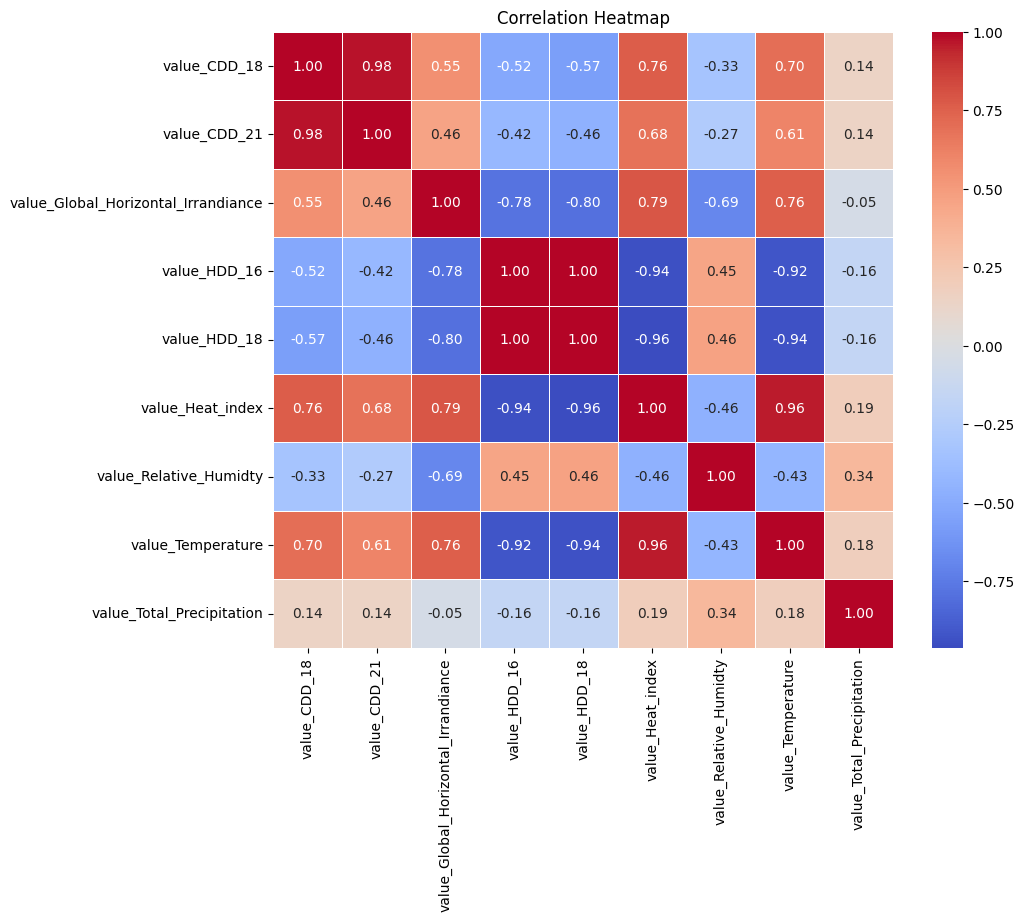

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = X.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [97]:

## We create a list of the columns we want to drop because of their high correlation
columns_to_drop = ['value_CDD_18', 'value_CDD_21', 'value_HDD_16', 'value_HDD_18', 'value_Heat_index']

## We drop the columns that have a too high correlation between each other
X = X.drop(columns=columns_to_drop)

X

,value_Global_Horizontal_Irrandiance,value_Relative_Humidty,value_Temperature,value_Total_Precipitation
0,0.598917,0.399736,0.867825,0.068503
1,0.611575,0.605880,0.556986,0.131309
2,0.600754,0.573670,0.605589,0.049963
3,0.564642,0.622398,0.397319,0.068166
4,0.479870,0.551867,0.612198,0.197151
...,...,...,...,...
6713,0.622150,0.447142,0.810801,0.086444
6714,0.259719,0.779980,0.603833,0.115480
6715,0.468806,0.762141,0.624622,0.309720
6716,0.349929,0.782128,0.690144,0.181534


### Here we run our Linear Regression after having dropped the highly correlated features

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

##X = pd.get_dummies(final, columns=categorical_columns, drop_first=True)
y = final['total target (wind, solar, hydro)']

# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model MinMaxScaler(feature_range=(0, 1)). We are dealing with GWh (energy) and prefer to have only positive values
model = LinearRegression()

# Fit 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
cod = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Coefficient of Determination (COD): {cod}')
print(f'R-squared: {r2}')

Mean Absolute Error: 9758.69486453704
Mean Squared Error: 375226568.35410905
Coefficient of Determination (COD): 0.04503795663993648
R-squared: 0.04503795663993648


## Plot of all features against the Total target (wind, solar, hydro)

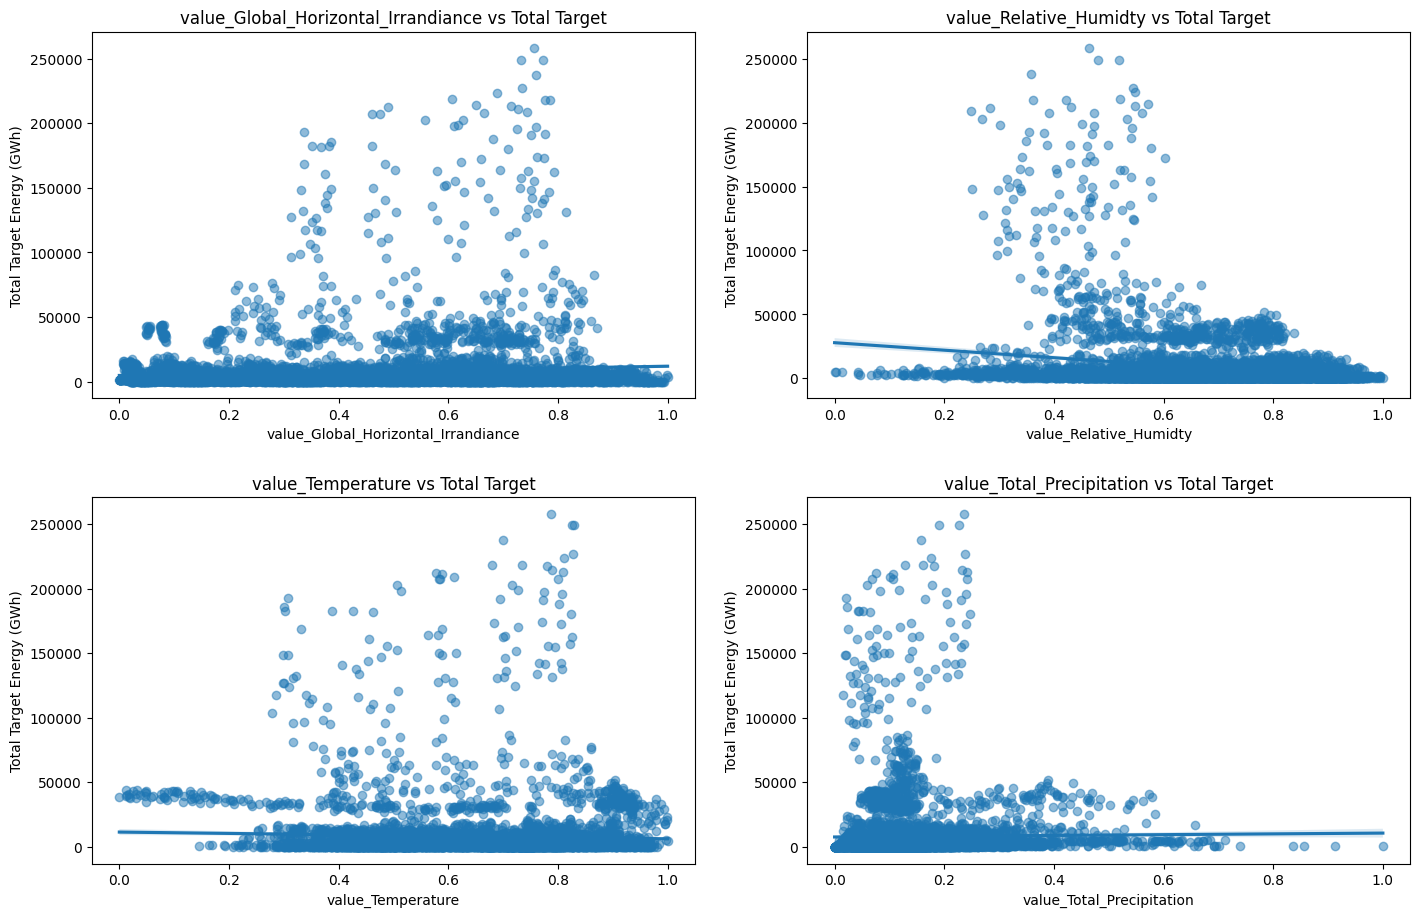

In [114]:
features = ['value_Global_Horizontal_Irrandiance',
    'value_Relative_Humidty',
    'value_Temperature',
    'value_Total_Precipitation']

num_features = len(features)
num_rows = num_features // 2 + num_features % 2  # Adjust for odd number of features

# Plotting subplots for each feature
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows * 5))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    
    # Plotting scatter plot with regression line
    sns.regplot(x=feature, y=final['total target (wind, solar, hydro)'], data=final, ax=axes[row, col], scatter_kws={'alpha':0.5})
    
    axes[row, col].set_title(f'{feature} vs Total Target')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Total Target Energy (GWh)')

# Remove empty subplots if there are an odd number of features
if num_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()

In [126]:
## We first select the columns that are gonna be part of our X 
##columns_X = [col for (col in final.columns if 'value' in col)]or (col in final.columns if 'Country' in col)]
columns_X = [col for col in final.columns if 'value' in col or 'Country' in col or 'Month_year' in col]

##  We're selecting the columns named with 'value'
X = final[columns_X]
X

,Month_year,Country,value_CDD_18,value_CDD_21,value_Global_Horizontal_Irrandiance,value_HDD_16,value_HDD_18,value_Heat_index,value_Relative_Humidty,value_Temperature,value_Total_Precipitation
0,2010-04-01,Australia,0.111464,3.712857e-02,0.598917,0.019489,0.038689,0.639927,0.399736,0.867825,0.068503
1,2010-04-01,Austria,0.000126,0.000000e+00,0.611575,0.255355,0.300292,0.435803,0.605880,0.556986,0.131309
2,2010-04-01,Belgium,0.002296,0.000000e+00,0.600754,0.218429,0.264712,0.459624,0.573670,0.605589,0.049963
3,2010-04-01,Canada,0.000159,6.825537e-08,0.564642,0.275212,0.319491,0.423290,0.622398,0.397319,0.068166
4,2010-04-01,Chile,0.003268,1.182407e-04,0.479870,0.126060,0.175605,0.518065,0.551867,0.612198,0.197151
...,...,...,...,...,...,...,...,...,...,...,...
6713,2022-09-01,Spain,0.261232,1.424242e-01,0.622150,0.006335,0.014242,0.700143,0.447142,0.810801,0.086444
6714,2022-09-01,Sweden,0.000000,0.000000e+00,0.259719,0.152834,0.205551,0.497448,0.779980,0.603833,0.115480
6715,2022-09-01,Switzerland,0.009257,0.000000e+00,0.468806,0.122044,0.164441,0.527046,0.762141,0.624622,0.309720
6716,2022-09-01,United Kingdom,0.006607,0.000000e+00,0.349929,0.073260,0.118218,0.556440,0.782128,0.690144,0.181534


In [127]:
#categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

#one-hot encoding to categorical columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
X

,Month_year,value_CDD_18,value_CDD_21,value_Global_Horizontal_Irrandiance,value_HDD_16,value_HDD_18,value_Heat_index,value_Relative_Humidty,value_Temperature,value_Total_Precipitation,...,Country_Portugal,Country_Romania,Country_Serbia,Country_Slovak Republic,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,Country_United States
0,2010-04-01,0.111464,3.712857e-02,0.598917,0.019489,0.038689,0.639927,0.399736,0.867825,0.068503,...,False,False,False,False,False,False,False,False,False,False
1,2010-04-01,0.000126,0.000000e+00,0.611575,0.255355,0.300292,0.435803,0.605880,0.556986,0.131309,...,False,False,False,False,False,False,False,False,False,False
2,2010-04-01,0.002296,0.000000e+00,0.600754,0.218429,0.264712,0.459624,0.573670,0.605589,0.049963,...,False,False,False,False,False,False,False,False,False,False
3,2010-04-01,0.000159,6.825537e-08,0.564642,0.275212,0.319491,0.423290,0.622398,0.397319,0.068166,...,False,False,False,False,False,False,False,False,False,False
4,2010-04-01,0.003268,1.182407e-04,0.479870,0.126060,0.175605,0.518065,0.551867,0.612198,0.197151,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6713,2022-09-01,0.261232,1.424242e-01,0.622150,0.006335,0.014242,0.700143,0.447142,0.810801,0.086444,...,False,False,False,False,False,True,False,False,False,False
6714,2022-09-01,0.000000,0.000000e+00,0.259719,0.152834,0.205551,0.497448,0.779980,0.603833,0.115480,...,False,False,False,False,False,False,True,False,False,False
6715,2022-09-01,0.009257,0.000000e+00,0.468806,0.122044,0.164441,0.527046,0.762141,0.624622,0.309720,...,False,False,False,False,False,False,False,True,False,False
6716,2022-09-01,0.006607,0.000000e+00,0.349929,0.073260,0.118218,0.556440,0.782128,0.690144,0.181534,...,False,False,False,False,False,False,False,False,True,False


# Lasso Analysis

In [90]:
from sklearn.linear_model import Lasso, Ridge

In [115]:
##  We're selecting the columns named with 'value'
X = final[columns_X] # For the Lasso we use all our features, even the ones that are highly correlated
y = final['total target (wind, solar, hydro)']

# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  L1 regularization (Lasso)
model_lasso = Lasso(alpha=0.01) ## Play with different alpha
model_lasso.fit(X_train, y_train)

# predictions on the testing data
y_pred_lasso = model_lasso.predict(X_test)

# Mean Absolute Error
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

# Coefficient of Determination (COD)
cod_lasso = r2_score(y_test, y_pred_lasso)

print(f'Mean Absolute Error (Lasso): {mae_lasso}')
print(f'Coefficient of Determination (COD) - Lasso: {cod_lasso}')

Mean Absolute Error (Lasso): 8778.959143644986
Coefficient of Determination (COD) - Lasso: 0.3831583627923919


/Users/sylvainvanhuysse/.pyenv/versions/3.10.6/envs/Power-Predict/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e+11, tolerance: 2.725e+08
  model = cd_fast.enet_coordinate_descent(


# Polynomial Transformation